In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import display, HTML

**Process annotation file**

In [2]:
# Load data and get basic info
df = pd.read_excel(
    "/home/dl18206/Desktop/phd/data/panaf/camera_reaction/annotations/Species_Database.xlsx",
    sheet_name="Western_chimpanzee",
)

# convert all column names to lower case
df.columns = df.columns.str.lower()

# remove rows where video_name is null
df = df[df["video_name"].notnull()]

# assert all video_name end with .0
assert all(df["video_name"].astype(str).str.endswith(".0"))

# remove .0 from video_name
df["video_name"] = df["video_name"].astype(str).str[:-2]

# Make a new column which combines transect_id and video_name
df["transect_video_id"] = (
    df["transect_id"].astype(str) + "_" + df["video_name"].astype(str)
)

# Make all transect_video_id lower case
df["transect_video_id"] = df["transect_video_id"].str.lower()

FileNotFoundError: [Errno 2] No such file or directory: 'annotations/Species_Database.xlsx'

**Process transect ID and names of local video**

In [ ]:
# Analyse files stored locally
path = "/home/dl18206/Desktop/phd/data/panaf/camera_reaction/adiko/videos/chimps/full/transects"
full_path = glob(path + "/**/*.MP4", recursive=True)
files = [x.split(".")[0] for x in full_path]

# get transect and video name
transect = [f.split("/")[-2] for f in files]
video = [f.split("/")[-1] for f in files]

# remove leading zerios from video names
video = [v.lstrip("0") for v in video]

# combine transect and video name by /
video = [t + "_" + v for t, v in zip(transect, video)]

# make all lower case
video = [v.lower() for v in video]

df_local = pd.DataFrame({"transect_video_id": video, "full_path": full_path})

**Rename videos to transect_video_id**

In [ ]:
# Rename videos to be a combination of transect and video_id
videos = glob(
    "/home/dl18206/Desktop/phd/data/panaf/camera_reaction/adiko/videos/chimps/full/**/*.MP4",
    recursive=True,
)
videos_dir = (
    "/home/dl18206/Desktop/phd/data/panaf/camera_reaction/adiko/videos/chimps/full"
)
for v in tqdm(videos):
    filename = v.split("/")[-1].split(".")[0].lstrip("0")
    transect = v.split("/")[-2]
    new_filename = f"{transect}_{filename}.mp4"
    new_filename = new_filename.lower()
    os.rename(v, os.path.join(videos_dir, new_filename))

**Proportion of videos with (and without) camera reaction**

In [ ]:
tmp = merged_df[["transect_video_id", "full_path"]].drop_duplicates()
camera_reaction_df = (
    merged_df.groupby("transect_video_id")[["reactivity"]]
    .apply(lambda x: (x["reactivity"] == "With reaction").any())
    .reset_index()
    .rename({0: "camera_reaction"}, axis=1)
)
camera_reaction_df = camera_reaction_df.merge(tmp, on="transect_video_id")

**Processing for annotation**

In [14]:
tmp_df = pd.DataFrame(
    df.groupby("transect_video_id")["behaviour"].apply(lambda x: list(set(x)))
)
tmp_df = pd.DataFrame({"behaviour": tmp_df.behaviour}).reset_index()

for b in df.behaviour.unique():
    tmp_df[b] = tmp_df.behaviour.apply(lambda x: True if b in x else False)
tmp_df.columns = tmp_df.columns.str.lower()

local_videos = [
    x.split("/")[-1].split(".")[0]
    for x in glob(
        "/home/dl18206/Desktop/phd/data/panaf/camera_reaction/adiko/videos/chimps/full/all/**/*.mp4",
        recursive=True,
    )
]

tmp_df[tmp_df.transect_video_id.isin(local_videos)]
tmp_df.rename(columns={"transect_video_id": "video"}, inplace=True)

<AxesSubplot:>

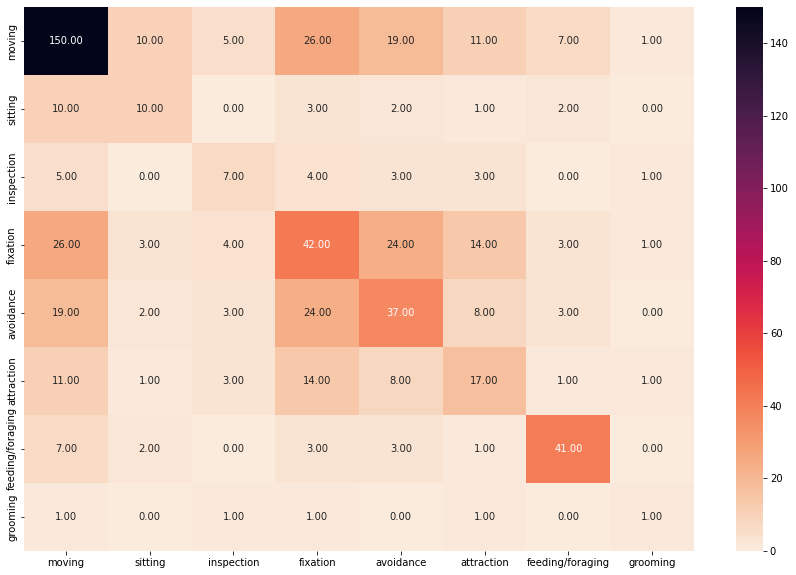

In [15]:
attr = tmp_df.columns[2:]

# Plot co-occurence matrix
coocc_df = tmp_df[attr].astype(int)
coocc = coocc_df.T.dot(coocc_df)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(coocc, cmap="rocket_r", annot=True, fmt=".2f")

In [16]:
# F = staring at the camera/inspecting the camera
# P = No reaction
# A = coming closer to the camera (because the camera was spotted. We can see that the chimpanzee noticed the camera, and they are now
#     getting closer to inspect it)
# R = Moving away from the camera (because the camera was spotted. We can see that the chipmanzee noticed the camera, and they are now
#     going away from it, often quicky as affraid of it)

In [17]:
# Group inspection and fixation as per benjamins annotations
# This is wrong (maybe) should both be grouped into attraction as per Adikos ethogram
# Ask Christophe about this grouping
tmp_df["inspection_or_fixation"] = tmp_df["inspection"] | tmp_df["fixation"]

# No reaction column
tmp_df["reaction"] = (
    tmp_df["inspection"]
    | tmp_df["fixation"]
    | tmp_df["avoidance"]
    | tmp_df["attraction"]
)
tmp_df["no_reaction"] = ~tmp_df["reaction"]

# Effectively use no_reaction to cover moving, sitting, feeding/foraging, grooming
tmp_df.drop(
    columns=[
        "inspection",
        "fixation",
        "reaction",
        "moving",
        "sitting",
        "feeding/foraging",
        "grooming",
    ],
    inplace=True,
)

tmp_df.rename(
    columns={"inspection_or_fixation": "inspection", "behaviour": "react"}, inplace=True
)

In [18]:
to_label = lambda x: ",".join([str(i) for i in x])
tmp_df["label"] = (
    tmp_df[tmp_df.columns[2:]].astype(int).apply(to_label, axis=1).astype("category")
)
tmp_df["label"] = tmp_df.label.str.split(",")
tmp_df["label"] = tmp_df.label.apply(lambda x: [int(i) for i in x])

In [20]:
tmp_df

,video,react,avoidance,attraction,inspection,no_reaction,label
0,adk01_8230044,"[Moving, Sitting]",False,False,False,True,"[0, 0, 0, 1]"
1,adk18_11090152,"[Moving, Sitting]",False,False,False,True,"[0, 0, 0, 1]"
2,adk20_10020263,[Moving],False,False,False,True,"[0, 0, 0, 1]"
3,adk20_10100389,[Moving],False,False,False,True,"[0, 0, 0, 1]"
4,adk20_10100390,[Moving],False,False,False,True,"[0, 0, 0, 1]"
...,...,...,...,...,...,...,...
206,tai58_2220142,[Moving],False,False,False,True,"[0, 0, 0, 1]"
207,tai58_2220143,[Moving],False,False,False,True,"[0, 0, 0, 1]"
208,tai58_2220145,[Moving],False,False,False,True,"[0, 0, 0, 1]"
209,tai65_2070196,[Fixation],False,False,True,False,"[0, 0, 1, 0]"


**Write to CSV**

In [ ]:
tmp_df.to_csv("cotedivoire.csv", index=False)